In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as pl
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import r2_score


In [2]:
df = pd.read_csv('sap_storing_data_hu_project.csv')
df.drop_duplicates(subset = '#stm_sap_meldnr', keep = 'last',inplace = True)

C:\Users\hasso\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def column_outlier(strength, dataframe, columns):
    temp_dataframe = dataframe.copy()
    try:
        if strength == 's':
            strength=3
        elif strength == 'a':
            strength=1.5
    except:
        print("Invalid strength")
    for column in columns:
        Q1 = temp_dataframe[column].quantile(0.25)
        Q3 = temp_dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        temp_dataframe = temp_dataframe[~((temp_dataframe[column] < (Q1 - strength * IQR)) |(temp_dataframe[column] > (Q3 + strength* IQR)))]
    return temp_dataframe

In [4]:
def get_accuracy(r,zip_list):
    return len([ _ for x in zip_list if x[0]+r >= x[1] >= x[0]-r])/len(zip_list)

<h2>Data Cleaning </h2>

In [5]:
# ik zorg er hier voor dat de 'stm_progfh_in_duur' kolom naar floats gecast wordt
df.stm_progfh_in_duur = df.stm_progfh_in_duur.apply(lambda x: float(str(x).replace('-','').replace('*','').strip()))

# delete stm_fh_duur outliers
#df = column_outlier('a', df.copy(), ['stm_fh_duur'])


# voeg dummy kolommen voor seizoenen toe
df.stm_sap_melddatum = pd.to_datetime(df.stm_sap_melddatum)

df['date_offset'] = (df.stm_sap_melddatum.dt.month*100 + df.stm_sap_melddatum.dt.day - 320)%1300

df['seizoen_melding'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

df.drop(['date_offset'], axis=1)
df = df.join(pd.get_dummies(df.seizoen_melding))

# join de oorzaakcodes
o_df = pd.read_csv('Oorzaakcodes.csv', sep = ';')
o_df = o_df.rename(columns={'Code': 'stm_oorz_code'})
df = df.merge(o_df, on = 'stm_oorz_code', how = 'outer')

# join de goetrajectcodes
geo_df = pd.read_csv('geocodes.csv',sep = ';') 
geo_df = geo_df.rename(columns={'Code': 'stm_geo_mld'})
df = df.merge(geo_df, on = 'stm_geo_mld', how = 'outer') 

# join de Contractgebiedcodes
cg = pd.read_excel('Contractgebiedcodes.xlsx') 
cg = cg.rename(columns={'Code': 'stm_contractgeb_gst'})
df = df.merge(cg, on = 'stm_contractgeb_gst', how = 'outer') 

# join de techniekvelden
tgv_df = pd.read_csv('techniekvelden.csv', sep = ';')
tgv_df = tgv_df.rename(columns={'Letter': 'stm_techn_mld'})
df = df.merge(tgv_df, on = 'stm_techn_mld', how = 'outer') 

# maak target var bins zodat we classification kunnen gebruiken
error_margin  = 5
bins = [x for x in range(0,480,error_margin)]
labels = [x for x in range(1,len(bins))]
df['duration_bin'] = pd.cut(df['stm_fh_duur'], bins = bins, labels=labels)

error_margin1  = 5
bins1 = [x for x in range(0,480,error_margin1)]
labels1 = [x for x in range(1,len(bins1))]
df['duration_bin_reactie'] = pd.cut(df['stm_reactie_duur'], bins = bins1, labels=labels1)


# we willen alleen durations die niet gelijk zijn aan 0 en kleiner zijn dan 8 uur
df = df[(df.stm_fh_duur != 0) & (df.duration_bin <= 48)]
df = df[(df.stm_reactie_duur != 0) & (df.duration_bin_reactie <= 48)]


# kolom voor meltijd h
df['meldtijd_h'] = df.stm_sap_meldtijd.str.split(':').str[0]



In [6]:
df['weeknr']= df.stm_sap_melddatum.dt.isocalendar().week.apply(lambda x: 'w' + str(x))
df[['weeknr','stm_sap_melddatum' ]].head()

,weeknr,stm_sap_melddatum
302,w14,2018-04-05
303,w23,2018-06-05
305,w25,2018-06-19
333,w27,2007-07-05
334,w2,2007-01-10


In [7]:
df['stm_controle_dd'].dropna()

333       09/05/2007
334       26/11/2007
335       22/12/2009
336       20/12/2007
339       19/07/2010
             ...    
566583    07/08/2006
566584    14/02/2013
566588    25/04/2013
566589    25/11/2011
566590    07/12/2010
Name: stm_controle_dd, Length: 230739, dtype: object

In [8]:
pd.set_option('display.max_rows', None)

In [9]:
pd.set_option('display.max_columns', None)

<AxesSubplot:xlabel='stm_reactie_duur', ylabel='Density'>

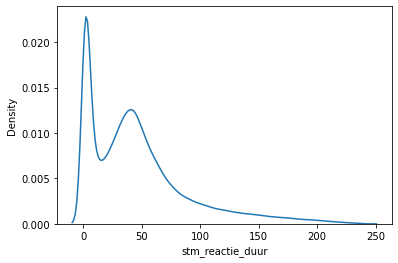

In [10]:
sns.kdeplot(df.stm_reactie_duur)

In [11]:
mean_durgeo_df = column_outlier('a', df.copy(), ['stm_reactie_duur'])[['stm_reactie_duur', 'Traject']].groupby('Traject', as_index = False).mean()
mean_durgeo_df

,Traject,stm_reactie_duur
0,Alkmaar,11.024390
1,Alkmaar - Uitgeest,32.571429
2,Almelo,44.142857
3,Almelo - Hengelo,22.000000
4,Alphen a/d Rijn,40.000000
5,Alphen a/d Rijn - Leiden Centraal,56.833333
6,Amersfoort,19.559322
7,Amersfoort Aansl.,31.750000
8,Amersfoort Aansl. - Barneveld Noord,51.500000
9,Amersfoort Aansl. - Hattemerbroek,52.600000


<AxesSubplot:xlabel='stm_reactie_duur', ylabel='Contractgebied'>

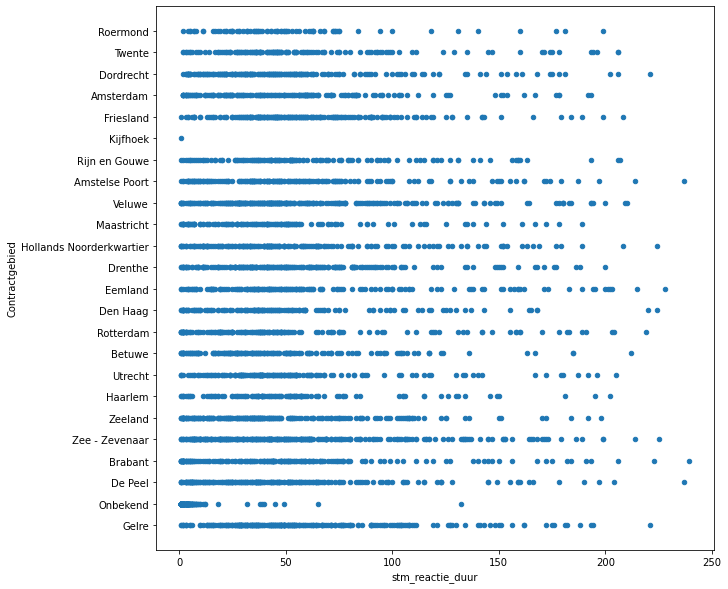

In [12]:
x = 'stm_reactie_duur'
y = 'Contractgebied'

tplot = df.sample(5000)[[x, y]]
tplot.sort_values(['stm_reactie_duur'], ascending=True, inplace=True)
tplot.dropna(inplace=True)

tplot.plot(x=x, y=y, kind='scatter',figsize=(10,10))

C:\Users\hasso\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-13-d63c207f4a1f>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=80, ha="right")


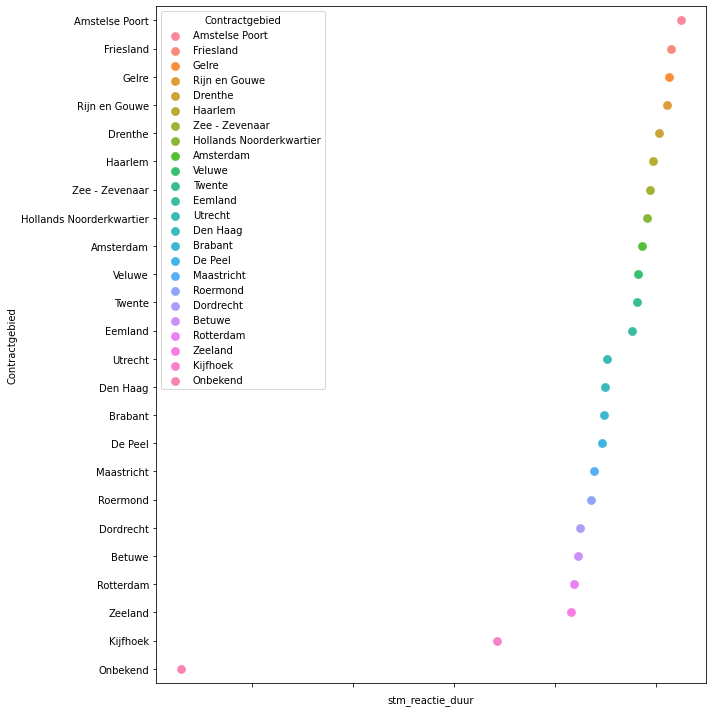

In [13]:
mean_cg_df = column_outlier('a', df.copy(), ['stm_reactie_duur'])[['stm_reactie_duur', 'Contractgebied']].groupby('Contractgebied', as_index = False).mean()
plt.figure(figsize=(10,10))
new_data= mean_cg_df.sort_values(by ='stm_reactie_duur' , ascending=False)
new_data_sort=new_data
ax=sns.pointplot(new_data_sort['stm_reactie_duur'], new_data_sort['Contractgebied'], hue=new_data_sort['Contractgebied'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=80, ha="right")
plt.tight_layout()
plt.show()


<h2> MODEL COMPARISON </h2>

In [ ]:
# svm, random forests en gaussion process classifier duren veels te lang op deze dataset

dt_df = df.copy()[['duration_bin', 'stm_equipm_nr_mld','stm_reactie_duur', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_km_van_mld','stm_fh_status']].dropna()


dt_df = dt_df.join(pd.get_dummies(df.stm_contractgeb_gst)).dropna()
dt_df = dt_df.join(pd.get_dummies(df.meldtijd_h)).dropna()
dt_df = dt_df.join(pd.get_dummies(df.Oorzaak)).dropna()
dt_df = dt_df.join(pd.get_dummies(df.stm_techn_mld)).dropna()
dt_df = dt_df.join(pd.get_dummies(df.weeknr)).dropna()
dt_df = dt_df.join(pd.get_dummies(df.stm_equipm_soort_mld)).dropna()
dt_df = dt_df.join(pd.get_dummies(df.Traject)).dropna()



X = dt_df.drop(columns = ['duration_bin'])
y = dt_df['duration_bin']



X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.2)

# c = GridSearchCV(DecisionTreeClassifier(random_state = 0), {'max_depth' : [22,32,42]})
# clf = c.fit(X_train_dt, y_train_dt)

clf = DecisionTreeClassifier(max_depth = 22, random_state = 0).fit(X_train_dt, y_train_dt)
y_pred_dt = clf.predict(X_test_dt)


y1_ax = [get_accuracy(x, list(zip(list(y_test_dt), y_pred_dt))) for x in range(0,30)]

accuracy_score(y_test_dt,y_pred_dt)

In [ ]:
classifier = tree.DecisionTreeRegressor()
y_pred = classifier.fit(X_train_dt, y_train_dt).predict(X_test_dt)
# accuracy_training = accuracy_score(y_val, y_pred)
classifier.metrics.accuracy_score()
accuracy_score(y_test_dt,y_pred)

In [ ]:
corrMatrix = dt_df1.corr()
corrMatrix

In [ ]:
sns.set(rc = {'figure.figsize':(30,10)})
sns.heatmap(corrMatrix, annot=True)


In [ ]:
corrMatrix.boxplot(figsize=(30,10))

In [ ]:
dt_df1 = df.copy()[['duration_bin_reactie', 'stm_km_tot_mld', 'stm_km_van_mld','spring', 'summer','autumn','winter']].dropna()
dt_df1 = dt_df1.join(pd.get_dummies(df.stm_contractgeb_gst)).dropna()
dt_df1 = dt_df1.join(pd.get_dummies(df.stm_techn_mld)).dropna()
dt_df1 = dt_df1.join(pd.get_dummies(df.meldtijd_h)).dropna()
dt_df1 = dt_df1.join(pd.get_dummies(df.Traject)).dropna()



X1 = dt_df1.drop(columns = ['duration_bin_reactie'])
y1 = dt_df1['duration_bin_reactie']

X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X1, y1, test_size=0.2)



clf = DecisionTreeClassifier(max_depth = 22, random_state = 0).fit(X_train_dt, y_train_dt)
y_pred_dt = clf.predict(X_test_dt)

accuracy_score(y_test_dt,y_pred_dt)

In [ ]:
# svm, random forests en gaussion process classifier duren veels te lang op deze dataset

kn_df = df[['duration_bin','stm_equipm_nr_mld','stm_reactie_duur', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_rapportage_jaar','spring', 'summer','autumn','winter']].dropna()

X = kn_df.drop(columns = ['duration_bin'])
y = kn_df.duration_bin


X_train_kn, X_test_kn, y_train_kn, y_test_kn = train_test_split(X, y, test_size=0.2)

clf2 = KNeighborsClassifier(n_neighbors = 1).fit(X_train_kn, y_train_kn)

y_pred_kn = clf2.predict(X_test_kn)

y2_ax = [get_accuracy(x, list(zip(list(y_test_kn), y_pred_kn))) for x in range(0,30)]

accuracy_score(y_test_kn,y_pred_kn)

In [ ]:
# vergelijk prorail prognose van hersteltijd met daadwerkelijke hersteltijd
bins = [x for x in range(0,480,error_margin)]
labels = [x for x in range(1,len(bins))]
prog_df = df.copy()[['stm_progfh_in_duur','duration_bin']]
prog_df = column_outlier('a', prog_df.copy(), ['stm_progfh_in_duur'])
prog_df['prog_duration_bin'] = pd.cut(prog_df['stm_progfh_in_duur'], bins = bins, labels=labels)
prog_df = prog_df.dropna()
prog_df = prog_df[['duration_bin', 'prog_duration_bin']]

y3_ax = [get_accuracy(x, list(zip(list(prog_df.duration_bin), list(prog_df.prog_duration_bin)))) for x in range(0,30)]

In [ ]:
x_ax = [error_margin +(20*x) for x in range(0,30)]


plt.plot(x_ax,y1_ax, label = 'Decision Tree')
plt.plot(x_ax,y2_ax, label = 'kNN')
plt.plot(x_ax,y3_ax, label = 'ProRail Prognose')


plt.xlabel('bin size in minutes')
plt.ylabel('accuracy score')

plt.legend()
plt.show()


In [ ]:
labels = ['Decision Tree', 'kNN', 'ProRail Prognose']

bar_1 = [100 * eval(f"y{i}_ax[0]") for i in range(1,len(labels)+1)]
bar_2 = [100 * (eval(f"y{i}_ax[1]") - eval(f"y{i}_ax[0]")) for i in range(1,len(labels)+1)]
bar_3 = [100 * (eval(f"y{i}_ax[2]") - eval(f"y{i}_ax[1]")) for i in range(1,len(labels)+1)]
bar_4 = [100 * (eval(f"y{i}_ax[3]") - eval(f"y{i}_ax[2]")) for i in range(1,len(labels)+1)]

width = 0.4  

fig, ax = plt.subplots()

ax.bar(labels, bar_1, width, label=f'|pred_ht−target_ht| < {error_margin} (minuten)', color = '#00ff99')
ax.bar(labels, bar_2, width ,bottom=bar_1,label=f'|pred_ht−target_ht| < {2*error_margin} (minuten)', color = '#bfff00')
ax.bar(labels, bar_3, width ,bottom=(np.array(bar_2) + np.array(bar_1)),label=f'|pred_ht−target_ht| < {3*error_margin} (minuten)', color = '#ffbf00')
ax.bar(labels, bar_4, width ,bottom=(np.array(bar_2) + np.array(bar_1) + np.array(bar_3)),label=f'|pred_ht−target_ht| < {4*error_margin} (minuten)', color = '#ff4000')


ax.set_ylabel('succesvolle classificatie in %')
ax.set_title('Nauwkeurigheid hersteltijd predictions')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=30)

plt.show()

In [ ]:
list(X_train_dt.columns)

In [ ]:
list(X_train_kn.columns)

In [ ]:
# base chance for a right classification by guessing the most common bin
max(df.duration_bin.dropna().value_counts())/len(df.duration_bin.dropna())

In [ ]:
# decision tree
[y1_ax[0],y1_ax[1],y1_ax[2]]

In [ ]:
# kNN
[y2_ax[0],y2_ax[1],y2_ax[2]]

In [ ]:

# prorail prognose
[y3_ax[0],y3_ax[1],y3_ax[2]]